In [1]:
#Load the modules for data manipulation.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Load the module for visualizing NYC.
import geopandas as gpd
#Load the module for suppressing unwanted error messages.
import warnings
warnings.filterwarnings('ignore')

#Adjust visualization settings.
#sns.set_style()
plt.style.use('ggplot')
%matplotlib inline

In [2]:
#Load the Shapefile for NYC into a dataframe. The Shapefile is used to visualize NYC, and was retrieved from NYC Open Data. 
street_map = gpd.read_file('geo_export_629b3182-5516-4755-987b-f4106c7d8b99.shp')

#Load the dataset that will be used for this project. Omit unnecessary columns. 
shops = pd.read_csv('shops_pre_EDA.csv')
shops = shops.loc[:, 'name':]

#Dunkin' Donuts appears under two different names, which will be fixed now.
shops.loc[shops['name'] == "Dunkin Donuts", 'name'] = "Dunkin' Donuts"

In [3]:
#Function which restricts shops by the number of reviews
def reviews_range(df, minimum, maximum):
    """
    Returns the sub-dataframe of df such that minimum <= reviews <= maximum.
    """
    return df[df['reviews'].between(minimum, maximum)]

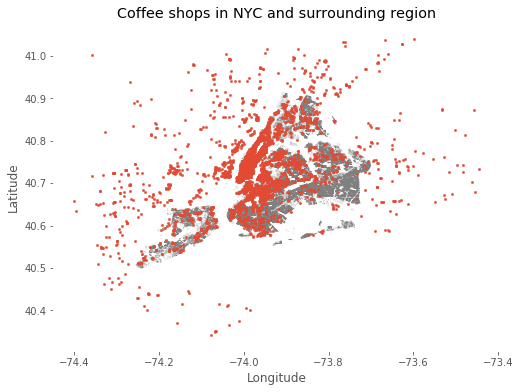

In [4]:
#Visualizing the coffee shop network before filtering out bad points.
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude', title='Coffee shops in NYC and surrounding region')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', s=5, data=shops)
ax.patch.set_facecolor('white');

Given that we are only interested in NYC coffee shops, the visualization above reveals many points that do not belong in the dataset. Any point which satisfies at least one of the following three bullets needs to be removed: 

•The longitude is outside of NYC's longitude range (which can be removed used a longitude filter). <br />
•The latitude is outside of NYC's latitude range (which can be removed used a latitude filter). <br /> 
•The coordinates are within NYC's longitude/latitude ranges but the point is not in NYC (which can be removed using appropriately-chosen rectangles). <br />

In [5]:
#Estimates for the longitude and latitude ranges of NYC, taken directly from Google Maps.
min_longitude_NYC = -74.255610
max_longitude_NYC = -73.700049
min_latitude_NYC = 40.496165
max_latitude_NYC = 40.915577

#Repeated application of the following functions will remove the points described in the third bullet above.
def remove_north_west_rectangle(df, corner_lat, corner_lon):
    """
    df is a dataframe with 'longitude' and 'latitude' columns.
    All points that are north-west of (corner_lat, corner_lon) will be filtered out of df.
    """
    return df[~((df['longitude']<corner_lon) & (df['latitude']>corner_lat))]

def remove_north_east_rectangle(df, corner_lat, corner_lon):
    """
    df is a dataframe with 'longitude' and 'latitude' columns.
    All points that are north-east of (corner_lat, corner_lon) will be filtered out of df.
    """
    return df[~((df['longitude']>corner_lon) & (df['latitude']>corner_lat))]

def remove_south_east_rectangle(df, corner_lat, corner_lon):
    """
    df is a dataframe with 'longitude' and 'latitude' columns.
    All points that are south-east of (corner_lat, corner_lon) will be filtered out of df.
    """
    return df[~((df['longitude']>corner_lon) & (df['latitude']<corner_lat))]

#Lists of coordinates that will be used as inputs for remove_north_west_rectangle(), remove_north_east_rectangle() and remove_south_east_rectangle().
#The coordinates were selected directly from Google Maps in such a way that no points in NYC are removed.
north_west_rectangle_corner = [(40.652578, -74.027496), (40.647619, -74.114938), (40.685464, -74.028357),
                               (40.707065, -74.020988), (40.739028, -74.013958), (40.757455, -74.010169),
                               (40.774145, -73.996326), (40.799351, -73.980336), (40.817706, -73.967623), 
                               (40.838019, -73.951854), (40.857452, -73.942018), (40.882348, -73.929711),
                               (40.908047, -73.916567), (40.910700, -73.890578), (40.800000, -73.970000), 
                               (40.560000, -74.200000)]
north_east_rectangle_corner = [(40.905783, -73.882172), (40.891769, -73.834559), (40.879946, -73.789872), 
                               (40.857882, -73.779249), (40.781774, -73.759754), (40.764539, -73.723468)]
south_east_rectangle_corner = [(40.720591, -73.725117), (40.644738, -73.739240), (40.737579, -73.700744),
                               (40.731155, -73.704537), (40.731099, -73.704888), (40.729896, -73.705880),
                               (40.728241, -73.706477)]

In [6]:
#Remove points where the longitude falls outside of the longitude range of NYC or the latitude falls outside of the latitude range of NYC.
shops = shops[shops['longitude'].between(min_longitude_NYC, max_longitude_NYC) &\
              shops['latitude'].between(min_latitude_NYC, max_latitude_NYC)]

#Remove rectangles of points within the longitude/latitude ranges of NYC which are not in NYC.
for (lat, lon) in north_west_rectangle_corner:
    shops = remove_north_west_rectangle(shops, lat, lon)
for (lat, lon) in north_east_rectangle_corner:
    shops = remove_north_east_rectangle(shops, lat, lon)
for (lat, lon) in south_east_rectangle_corner:
    shops = remove_south_east_rectangle(shops, lat, lon)

#Reset the row indices of shops to make indexing easier: 0,1,2,...
shops.index = list(range(shops.shape[0]))

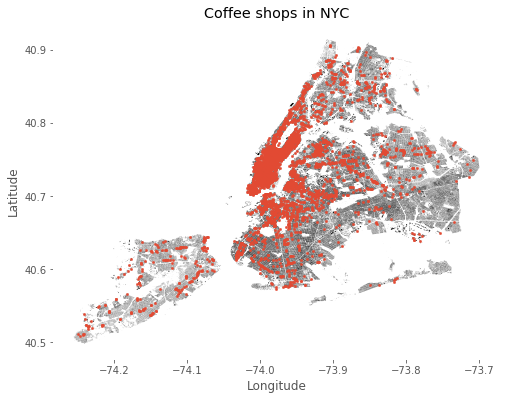

In [7]:
#Visualizing the coffee shop network after filtering out bad points.
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude', title='Coffee shops in NYC')
street_map.plot(ax=ax, alpha=1, color='black')
plt.scatter(x='longitude', y='latitude', s=5, data=shops)
ax.patch.set_facecolor('white');

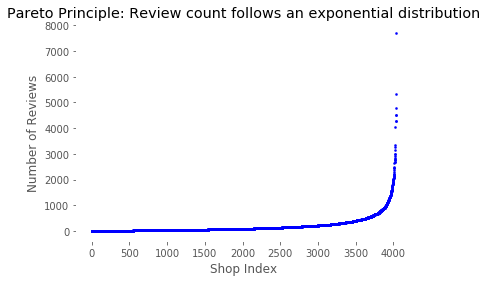

In [8]:
#Visualizing review counts in increasing order.
reviews_sorted = shops['reviews'].sort_values()
number_shops = len(reviews_sorted)
#Define the indices for the points (0,1,2...), to be used for the x-axis values in the scatterplot.
indices = list(range(number_shops))

fig, ax = plt.subplots(figsize = (6,4))
plt.scatter(indices, reviews_sorted, s=4, color='blue')
plt.xlabel('Shop Index')
plt.ylabel('Number of Reviews')
plt.title("Pareto Principle: Review count follows an exponential distribution")
ax.patch.set_facecolor('white');

In [9]:
#Pareto's Law: the highest 20% of shops by reviews contribute 69% of the total review count across all shops.
shops_lowest_80 = reviews_sorted[:int(0.8*number_shops)]
shops_highest_20 = reviews_sorted[int(0.8*number_shops):]
sum(shops_highest_20) / (sum(shops_highest_20) + sum(shops_lowest_80))

0.6858038563504096

In [10]:
#Summary statistics for the distribution of reviews
shops['reviews'].describe().astype(int)

count    4036
mean      207
std       393
min         1
25%        33
50%        86
75%       217
max      7693
Name: reviews, dtype: int32

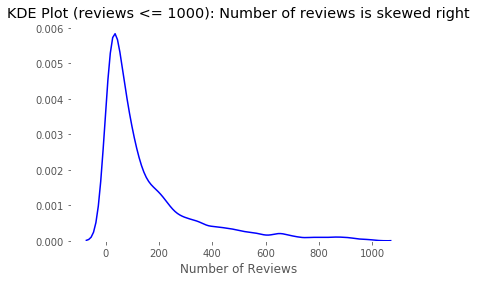

In [11]:
#Univariate analysis of reviews restricted to reviews<=1000; the continuous analog of a histogram.

#The dataframe for the KDE plot
shops_reviews_1_1000 = reviews_range(shops, 1, 1000)

#Creating the KDE plot.
fig, ax = plt.subplots(1, figsize=(6,4))
sns.kdeplot(shops_reviews_1_1000['reviews'], ax=ax, legend=False, color='blue')
ax.set(xlabel='Number of Reviews', title='KDE Plot (reviews <= 1000): Number of reviews is skewed right')
ax.patch.set_facecolor('white');

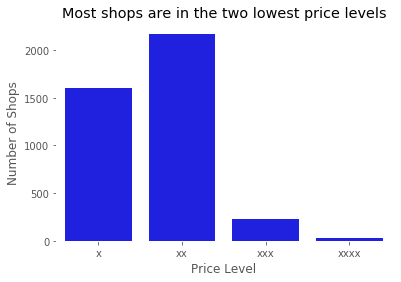

In [12]:
#Univariate analysis of price.

#Creating the dataframe for the bar chart.
price_counts = shops['price'].value_counts()
price_counts_df = pd.DataFrame({'price':price_counts.index, 'count':price_counts.values})

#Creating the bar chart.
fig, ax = plt.subplots(1, figsize=(6,4))
ax = sns.barplot(x='price', y='count', data=price_counts_df, order=['x','xx','xxx','xxxx'], color='blue')
ax.set(xlabel='Price Level', ylabel='Number of Shops', title="Most shops are in the two lowest price levels")
ax.patch.set_facecolor('white');

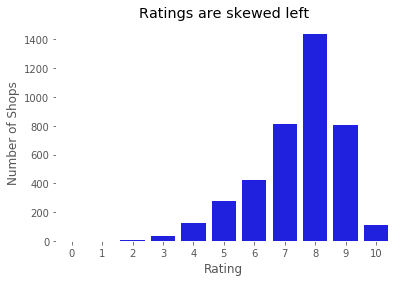

In [13]:
#Univariate analysis of ratings.

#Creating the dataframe for the bar chart.
rating_counts = shops['rating'].value_counts()
rating_counts_df = pd.DataFrame({'rating':rating_counts.index, 'count':rating_counts.values})

#Creating the bar chart.
fig, ax = plt.subplots(1, figsize=(6,4))
ax = sns.barplot(x='rating', y='count', data=rating_counts_df, color='blue')
ax.set(xlabel='Rating', ylabel='Number of Shops', title="Ratings are skewed left")
ax.patch.set_facecolor('white');

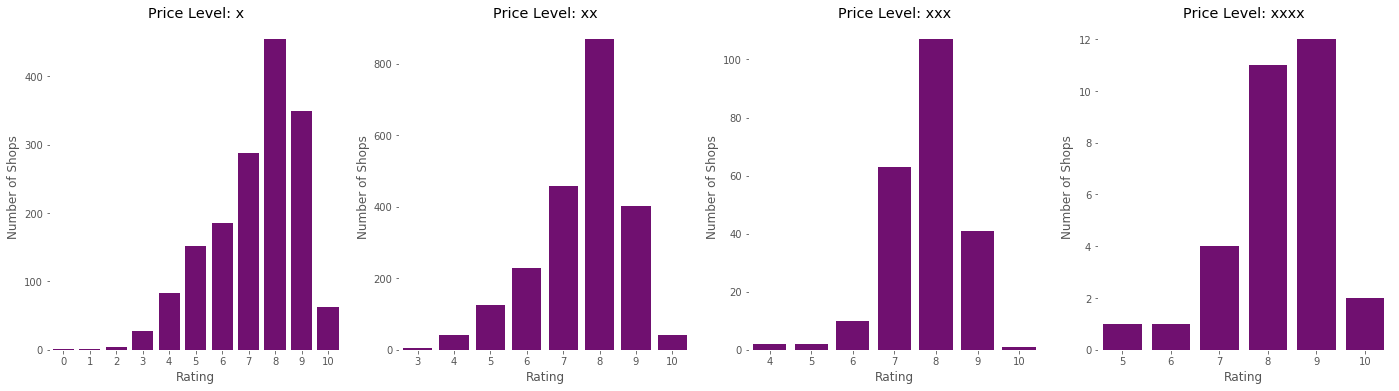

In [14]:
#Bivariate analysis of ratings vs. price group.

#Define the relevant dataframes to be used in sns.barplot(). This could also be done using groupby.
#There is one dataframe for each price level (x, xx, xxx, xxxx) and each gives a count for the different values of 'rating'.
rating_counts_x = shops[shops['price']=='x']['rating'].value_counts()
rating_counts_x_df = pd.DataFrame({'rating':rating_counts_x.index, 'count':rating_counts_x.values})
rating_counts_xx = shops[shops['price']=='xx']['rating'].value_counts()
rating_counts_xx_df = pd.DataFrame({'rating':rating_counts_xx.index, 'count':rating_counts_xx.values})
rating_counts_xxx = shops[shops['price']=='xxx']['rating'].value_counts()
rating_counts_xxx_df = pd.DataFrame({'rating':rating_counts_xxx.index, 'count':rating_counts_xxx.values})
rating_counts_xxxx = shops[shops['price']=='xxxx']['rating'].value_counts()
rating_counts_xxxx_df = pd.DataFrame({'rating':rating_counts_xxxx.index, 'count':rating_counts_xxxx.values})

#Create the bar charts.
fig, ax = plt.subplots(1,4,figsize=(24,6))
sns.barplot(x='rating', y='count', data=rating_counts_x_df, ax=ax[0], color='purple')
sns.barplot(x='rating', y='count', data=rating_counts_xx_df, ax=ax[1], color='purple')
sns.barplot(x='rating', y='count', data=rating_counts_xxx_df, ax=ax[2], color='purple')
sns.barplot(x='rating', y='count', data=rating_counts_xxxx_df, ax=ax[3], color='purple')
ax[0].set(xlabel='Rating', ylabel="Number of Shops", title='Price Level: x')
ax[1].set(xlabel='Rating', ylabel="Number of Shops", title='Price Level: xx')
ax[2].set(xlabel='Rating', ylabel="Number of Shops", title='Price Level: xxx')
ax[3].set(xlabel='Rating', ylabel="Number of Shops", title='Price Level: xxxx')
ax[0].patch.set_facecolor('white')
ax[1].patch.set_facecolor('white')
ax[2].patch.set_facecolor('white')
ax[3].patch.set_facecolor('white');

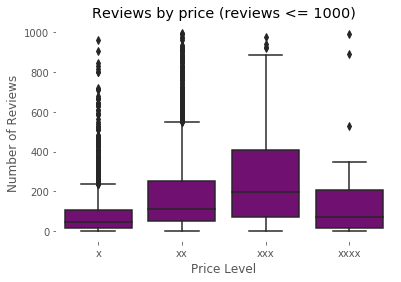

In [15]:
#Bivariate analysis of reviews vs. price.
fig, ax = plt.subplots(1, figsize=(6,4))
sns.boxplot(x='price', y='reviews', data=reviews_range(shops,1,1000), ax=ax, order=['x','xx','xxx','xxxx'], color='purple')
ax.set(xlabel='Price Level', ylabel="Number of Reviews", title='Reviews by price (reviews <= 1000)')
ax.patch.set_facecolor('white');

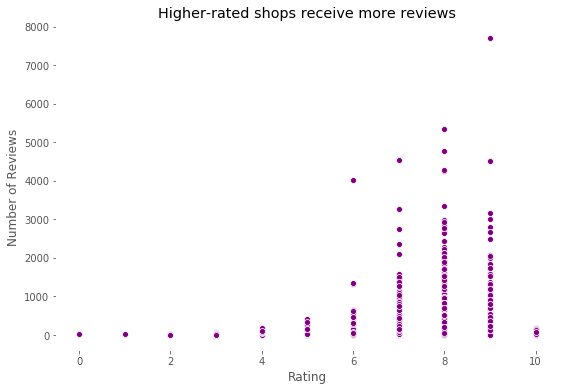

In [16]:
#Bivariate analysis of reviews vs. rating.
fig, ax = plt.subplots(1, figsize=(9,6))
sns.scatterplot(x='rating', y='reviews', data=shops, color='purple')
ax.set(xlabel='Rating', ylabel="Number of Reviews", title='Higher-rated shops receive more reviews')
ax.patch.set_facecolor('white');

In [17]:
#Multivariate analysis of average reviews grouped by rating and price.

#Build an 11x4 dataframe where each cell corresponds to a unique (rating,price) pair, and the corresponding number of reviews.
reviews_heatmap_df = pd.DataFrame({'rating':[0,1,2,3,4,5,6,7,8,9,10]*4,
                                   'price': ['x']*11 + ['xx']*11 + ['xxx']*11 + ['xxxx']*11,
                                   'mean_reviews': [0]*44,
                                   'median_reviews': [0]*44})

#Fill in the values for mean_reviews and median_reviews in reviews_heatmap_df.
for row in range(44):
    price = reviews_heatmap_df.loc[row, 'price']
    rating = reviews_heatmap_df.loc[row, 'rating']
    shops_filtered = shops.loc[(shops['rating']==rating) & (shops['price']==price)]
    mean_reviews = np.mean(shops_filtered['reviews'])
    median_reviews = np.median(shops_filtered['reviews'])
    reviews_heatmap_df.loc[row, 'mean_reviews'] = mean_reviews
    reviews_heatmap_df.loc[row, 'median_reviews'] = median_reviews

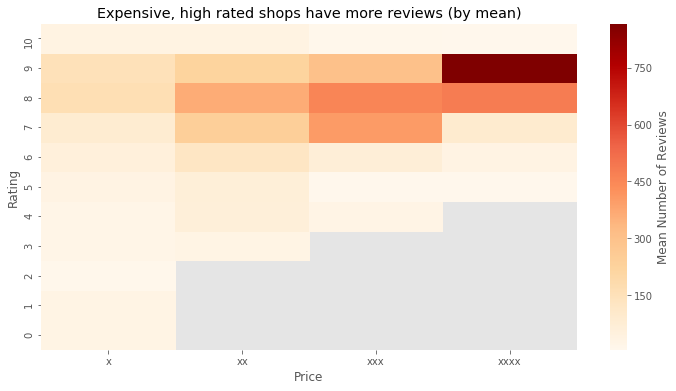

In [18]:
#Creating the first heatmap. 
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(reviews_heatmap_df.pivot("rating", "price", "mean_reviews"), cmap='OrRd',cbar_kws={'label': 'Mean Number of Reviews'})
ax.set(xlabel='Price', ylabel='Rating', title='Expensive, high rated shops have more reviews (by mean)')
ax.invert_yaxis();

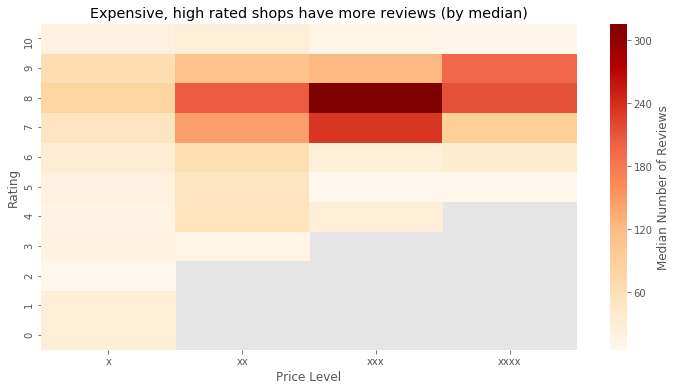

In [19]:
#Creating the second heatmap.
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(reviews_heatmap_df.pivot("rating", "price", "median_reviews"), cmap='OrRd',cbar_kws={'label': 'Median Number of Reviews'})
ax.set(xlabel='Price Level', ylabel='Rating', title='Expensive, high rated shops have more reviews (by median)')
ax.invert_yaxis();

In [ ]:
#The file that is to be loaded for the first version of the simulator.
shops.to_csv('shops_post_EDA.csv', index=False)